In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from termcolor import colored
import empyrical as emp
from utils import *
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('../HMM_randomportfolio.csv')
df.pricingdate = df.pricingdate.astype('datetime64')
df = df.set_index(df.pricingdate).drop('pricingdate', axis=1)
#df['predicted'] = np.zeros(len(df.priceclose))
df

,priceclose,r1,signal
pricingdate,,,
2001-01-03,268.633857,0.012004,1
2001-01-04,266.142144,-0.009275,0
2001-01-05,253.156482,-0.048792,0
2001-01-08,245.341326,-0.030871,0
2001-01-09,247.053257,0.006978,1
...,...,...,...
2022-05-24,1871.590002,0.002630,1
2022-05-25,1913.690022,0.022494,1
2022-05-26,1923.819968,0.005293,1


In [3]:
#Walk-Forward Data Preparation
experiment = WalkForward(df, 'signal', step=1, start_interval = 400)

Text(0.5, 1.0, 'Price of the first window')

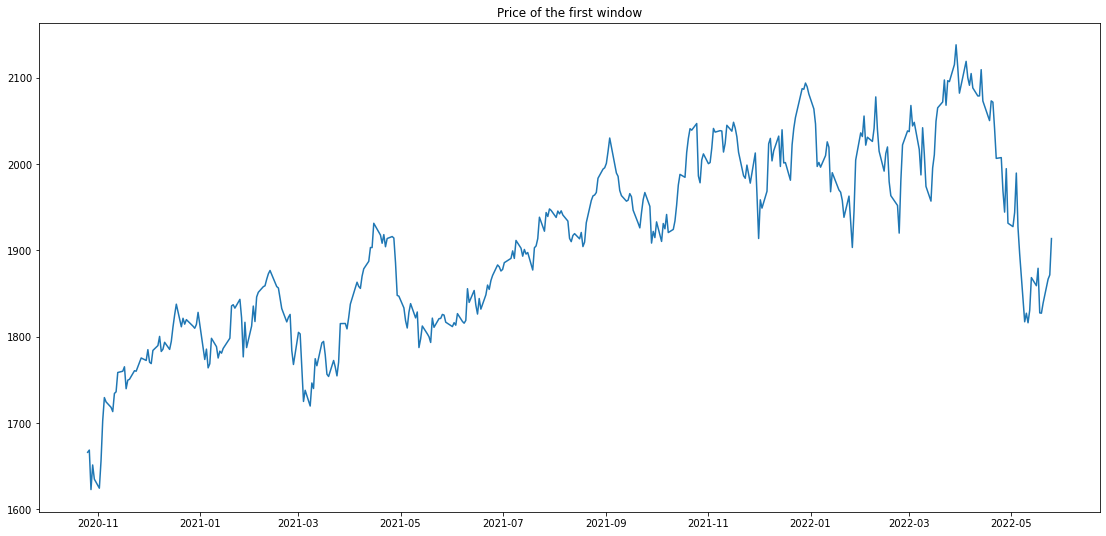

In [4]:
plt.figure(figsize = (19,9))
plt.plot(experiment[-2]['universe_train'].priceclose)
plt.title('Price of the first window')

In [5]:
S = ['B','S'] # buy, sell states

In [6]:
n_visible = len(df.signal.unique())
n_hidden = len(S)

In [7]:
def forward(V, A, B, pi):
    T = V.shape[0]
    N = A.shape[0]
    
    alpha = np.zeros((T,N))
    alpha[0] = pi[0] * B[:,V[0]]  
    for t in range(0,T-1): alpha[t+1] = np.array([alpha[t,:].dot(A[:,j]) * (B[j,V[t+1]]) for j in range(N)])
            
    return alpha

In [8]:
def backward(V, A, B):
    T = V.shape[0]
    N = A.shape[0]
    
    beta = np.zeros((T,N))
    beta[T-1] = np.ones((N))
    for t in range(T-2, -1, -1): beta[t] = np.array([(beta[t+1,:] * B[:,V[t+1]]).dot(A[j,:]) for j in range(N)])
            
    return beta

In [9]:
def viterbi(V,A,B,pi):
    T = V.shape[0]
    N = A.shape[0]

    alpha = forward(V, A, B, pi)
    beta = backward(V, A, B)

    xi = np.zeros((T, N, N))
    for t in range(T-1):
        denominator = sum(alpha[t,:].dot(A[:,:]) * B[:,V[t+1]] * beta[t+1,:])
        for i in range(N):
            for j in range(N):
                numerator = alpha[t,i] * A[i,j] * (B[j,V[t+1]]) * beta[t+1,j] 
                xi[t,i,j] = numerator / denominator 

           # note: gamma can be also computed as
    gamma = np.zeros((T,N))
    for t in range(T): gamma[t] = np.array([sum(xi[t,i,:]) for i in range(N)])

    return gamma, xi

In [10]:
def baum_welch(V, A, B, pi, max_iter=100, epsilon=1e-5, verbose=True):
    T = V.shape[0]
    N = A.shape[0]
    
    # initialization: for the first iteration, our estimated parameters will be the initial ones
    A_bar = A
    B_bar = B
    pi_bar = pi
    
    for iteration in range(max_iter):
        gamma, xi = viterbi(V, A_bar, B_bar, pi_bar)

        # expectation-maximization step
        pi_bar = np.array([gamma[0,i] for i in range(N)])

        prev = [A_bar, B_bar, pi_bar]
               
        A_bar = np.zeros((N,N))
        for i in range(N): A_bar[i] = np.array([xi[:-1,i,j].sum() / gamma[:-1,i].sum() for j in range(N)])

        B_bar = np.zeros(B.shape)
        for j in range(B.shape[0]):
            for k in range(B.shape[1]):
                # we need to define a list of times t_bar where V[t] is equal to k
                t_bar = [0,0]
                for i in [0,1]: t_bar[i] = [t for t in range(T) if V[t]==k]
                B_bar[j,k] = sum([gamma[t,j] for t in t_bar[k]]) / gamma[:,j].sum()
        
        A_delta = delta(A_bar, prev[0])
        B_delta = delta(B_bar, prev[1])
        pi_delta = delta(pi_bar, prev[2])
        
        e = A_delta + B_delta + pi_delta
        
        if verbose == True: print(f'iteration {iteration} - delta {e}')
        if e < epsilon: break

    return {'A_hat': A_bar, 'B_hat': B_bar, 'pi_hat': pi_bar, 'gamma': gamma}

In [78]:
#initialization of parameters
A_init = np.array([[.85,.15],
                  [.2,.8]])
B_init = np.array([[.8,.2],
                   [.2,.8]])
pi_init = np.array([1.05/2,.95/2])

In [79]:
est= baum_welch(experiment[0]['train_input'], A_init, B_init, pi_init, max_iter=500, epsilon=1e-25, verbose=True)

iteration 0 - delta 0.014183013745890332
iteration 1 - delta 0.004719252331500732
iteration 2 - delta 0.002113626895437694
iteration 3 - delta 0.0011293102454016071
iteration 4 - delta 0.0006752026461942336
iteration 5 - delta 0.00043639198732118434
iteration 6 - delta 0.0002986305288186181
iteration 7 - delta 0.00021349062574589
iteration 8 - delta 0.00015798771171518064
iteration 9 - delta 0.00012023188198886648
iteration 10 - delta 9.36402931347058e-05
iteration 11 - delta 7.436231280754907e-05
iteration 12 - delta 6.004071238701926e-05
iteration 13 - delta 4.917619872408079e-05
iteration 14 - delta 4.078351767743717e-05
iteration 15 - delta 3.4196703083776396e-05
iteration 16 - delta 2.8954398420454988e-05
iteration 17 - delta 2.4729998803811207e-05
iteration 18 - delta 2.128780997303857e-05
iteration 19 - delta 1.8454800356976203e-05
iteration 20 - delta 1.6101967697752683e-05
iteration 21 - delta 1.413178608971544e-05
iteration 22 - delta 1.2469586983308304e-05
iteration 23 - del

iteration 194 - delta 1.0810535261233151e-07
iteration 195 - delta 1.07859327208045e-07
iteration 196 - delta 1.0761885762600865e-07
iteration 197 - delta 1.0738378907932675e-07
iteration 198 - delta 1.0715397161154112e-07
iteration 199 - delta 1.0692925992410727e-07
iteration 200 - delta 1.0670951321092022e-07
iteration 201 - delta 1.0649459499813595e-07
iteration 202 - delta 1.0628437299110665e-07
iteration 203 - delta 1.0607871892579804e-07
iteration 204 - delta 1.0587750843062236e-07
iteration 205 - delta 1.0568062088637958e-07
iteration 206 - delta 1.0548793930051248e-07
iteration 207 - delta 1.0529935017795544e-07
iteration 208 - delta 1.0511474340286779e-07
iteration 209 - delta 1.0493401212280667e-07
iteration 210 - delta 1.0475705263597128e-07
iteration 211 - delta 1.0458376428582593e-07
iteration 212 - delta 1.04414049356091e-07
iteration 213 - delta 1.0424781297449645e-07
iteration 214 - delta 1.0408496301618174e-07
iteration 215 - delta 1.0392541001100812e-07
iteration 216 

iteration 386 - delta 9.284371224870176e-08
iteration 387 - delta 9.279591594310761e-08
iteration 388 - delta 9.274796258975513e-08
iteration 389 - delta 9.269984999286743e-08
iteration 390 - delta 9.265157599337575e-08
iteration 391 - delta 9.260313846889115e-08
iteration 392 - delta 9.255453533459301e-08
iteration 393 - delta 9.25057645400804e-08
iteration 394 - delta 9.245682407117185e-08
iteration 395 - delta 9.240771194735624e-08
iteration 396 - delta 9.235842622265518e-08
iteration 397 - delta 9.230896498436504e-08
iteration 398 - delta 9.225932635297416e-08
iteration 399 - delta 9.220950848156316e-08
iteration 400 - delta 9.2159509554487e-08
iteration 401 - delta 9.210932778838059e-08
iteration 402 - delta 9.205896143044958e-08
iteration 403 - delta 9.200840875773088e-08
iteration 404 - delta 9.195766807959285e-08
iteration 405 - delta 9.190673773258546e-08
iteration 406 - delta 9.185561608347612e-08
iteration 407 - delta 9.180430152833484e-08
iteration 408 - delta 9.17527924894

In [80]:
gennaro = est['gamma']
gennaro

array([[0.4548606 , 0.5451394 ],
       [0.53404589, 0.46595411],
       [0.5476911 , 0.4523089 ],
       [0.51392448, 0.48607552],
       [0.38788567, 0.61211433],
       [0.37497524, 0.62502476],
       [0.45575131, 0.54424869],
       [0.37032613, 0.62967387],
       [0.37212267, 0.62787733],
       [0.46384635, 0.53615365],
       [0.39965632, 0.60034368],
       [0.46368017, 0.53631983],
       [0.37157737, 0.62842263],
       [0.36864346, 0.63135654],
       [0.45046022, 0.54953978],
       [0.35934982, 0.64065018],
       [0.34006691, 0.65993309],
       [0.36357326, 0.63642674],
       [0.46526719, 0.53473281],
       [0.41280706, 0.58719294],
       [0.50699627, 0.49300373],
       [0.5004999 , 0.4995001 ],
       [0.38468726, 0.61531274],
       [0.37717154, 0.62282846],
       [0.4666348 , 0.5333652 ],
       [0.40374449, 0.59625551],
       [0.474784  , 0.525216  ],
       [0.40391171, 0.59608829],
       [0.46720178, 0.53279822],
       [0.37886476, 0.62113524],
       [0.

In [81]:
state= np.ones(len(gennaro))
for t in range(len(gennaro)): state[t] = np.argmax(gennaro[t])
experiment[0]['state'] = state

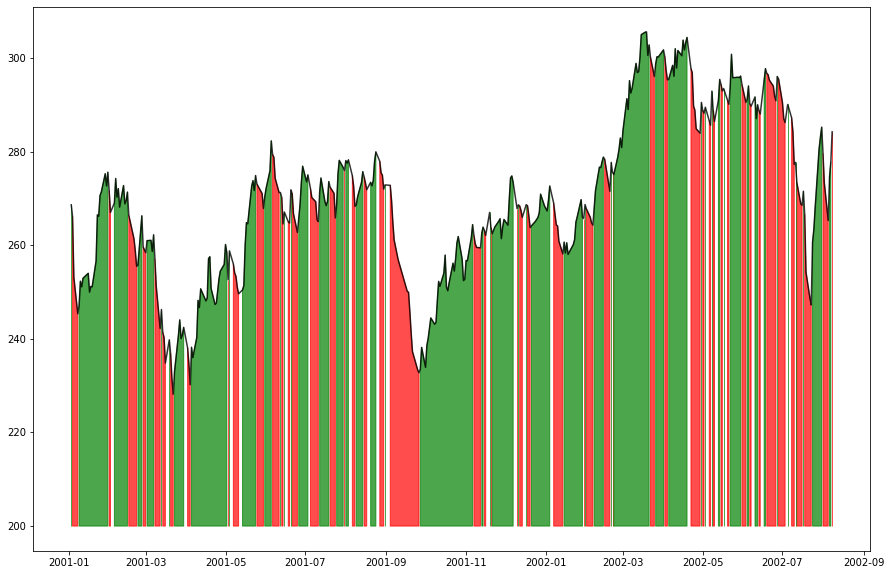

In [82]:
plt.figure(figsize=(15,10))
plt.plot(experiment[0]['universe_train'].priceclose, color='black',alpha=.8)
plt.fill_between(experiment[0]['universe_train'].index,experiment[0]['universe_train'].priceclose,200,where=experiment[0]['state']==0, color='red', alpha=.7)
plt.fill_between(experiment[0]['universe_train'].index,experiment[0]['universe_train'].priceclose,200,where=experiment[0]['state']==1, color='green', alpha=.7)

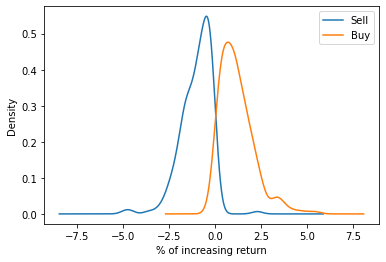

In [69]:
 # conditional distribution of r1 given the state
(experiment[0]['universe_train']['r1'][experiment[0]['state']==0]*100).plot.density()
(experiment[0]['universe_train']['r1'][experiment[0]['state']==1]*100).plot.density()
plt.legend(['Sell','Buy'])
plt.xlabel('% of increasing return')
plt.savefig('../results/signal_distribution.png')

In [18]:
predictions = []
for exp in range(len(experiment)):
    train = baum_welch(experiment[exp]['train_input'], A_init, B_init, pi_init, max_iter=100, epsilon=1e-19, verbose = 0)
    prediction = train['gamma'][-2].dot(train['A_hat']).argmax()
    print('experiment n.', exp, 'and his state prediction is:', prediction)
    predictions.append(prediction)

experiment n. 0 and his state prediction is: 1
experiment n. 1 and his state prediction is: 1
experiment n. 2 and his state prediction is: 1
experiment n. 3 and his state prediction is: 0
experiment n. 4 and his state prediction is: 0
experiment n. 5 and his state prediction is: 1
experiment n. 6 and his state prediction is: 1
experiment n. 7 and his state prediction is: 1
experiment n. 8 and his state prediction is: 0
experiment n. 9 and his state prediction is: 1
experiment n. 10 and his state prediction is: 0
experiment n. 11 and his state prediction is: 0
experiment n. 12 and his state prediction is: 0
experiment n. 13 and his state prediction is: 0
experiment n. 14 and his state prediction is: 0
experiment n. 15 and his state prediction is: 0
experiment n. 16 and his state prediction is: 0
experiment n. 17 and his state prediction is: 0
experiment n. 18 and his state prediction is: 1
experiment n. 19 and his state prediction is: 0
experiment n. 20 and his state prediction is: 1
ex

experiment n. 170 and his state prediction is: 1
experiment n. 171 and his state prediction is: 1
experiment n. 172 and his state prediction is: 1
experiment n. 173 and his state prediction is: 1
experiment n. 174 and his state prediction is: 1
experiment n. 175 and his state prediction is: 1
experiment n. 176 and his state prediction is: 1
experiment n. 177 and his state prediction is: 1
experiment n. 178 and his state prediction is: 1
experiment n. 179 and his state prediction is: 0
experiment n. 180 and his state prediction is: 1
experiment n. 181 and his state prediction is: 0
experiment n. 182 and his state prediction is: 0
experiment n. 183 and his state prediction is: 0
experiment n. 184 and his state prediction is: 0
experiment n. 185 and his state prediction is: 0
experiment n. 186 and his state prediction is: 0
experiment n. 187 and his state prediction is: 0
experiment n. 188 and his state prediction is: 0
experiment n. 189 and his state prediction is: 0
experiment n. 190 an

experiment n. 338 and his state prediction is: 0
experiment n. 339 and his state prediction is: 1
experiment n. 340 and his state prediction is: 1
experiment n. 341 and his state prediction is: 0
experiment n. 342 and his state prediction is: 1
experiment n. 343 and his state prediction is: 1
experiment n. 344 and his state prediction is: 0
experiment n. 345 and his state prediction is: 1
experiment n. 346 and his state prediction is: 1
experiment n. 347 and his state prediction is: 1
experiment n. 348 and his state prediction is: 0
experiment n. 349 and his state prediction is: 1
experiment n. 350 and his state prediction is: 1
experiment n. 351 and his state prediction is: 1
experiment n. 352 and his state prediction is: 0
experiment n. 353 and his state prediction is: 0
experiment n. 354 and his state prediction is: 1
experiment n. 355 and his state prediction is: 1
experiment n. 356 and his state prediction is: 0
experiment n. 357 and his state prediction is: 1
experiment n. 358 an

experiment n. 572 and his state prediction is: 1
experiment n. 573 and his state prediction is: 1
experiment n. 574 and his state prediction is: 1
experiment n. 575 and his state prediction is: 1
experiment n. 576 and his state prediction is: 1
experiment n. 577 and his state prediction is: 1
experiment n. 578 and his state prediction is: 1
experiment n. 579 and his state prediction is: 1
experiment n. 580 and his state prediction is: 1
experiment n. 581 and his state prediction is: 1
experiment n. 582 and his state prediction is: 1
experiment n. 583 and his state prediction is: 1
experiment n. 584 and his state prediction is: 1
experiment n. 585 and his state prediction is: 1
experiment n. 586 and his state prediction is: 1
experiment n. 587 and his state prediction is: 1
experiment n. 588 and his state prediction is: 1
experiment n. 589 and his state prediction is: 1
experiment n. 590 and his state prediction is: 1
experiment n. 591 and his state prediction is: 1
experiment n. 592 an

experiment n. 740 and his state prediction is: 1
experiment n. 741 and his state prediction is: 1
experiment n. 742 and his state prediction is: 1
experiment n. 743 and his state prediction is: 1
experiment n. 744 and his state prediction is: 1
experiment n. 745 and his state prediction is: 1
experiment n. 746 and his state prediction is: 1
experiment n. 747 and his state prediction is: 1
experiment n. 748 and his state prediction is: 1
experiment n. 749 and his state prediction is: 1
experiment n. 750 and his state prediction is: 1
experiment n. 751 and his state prediction is: 1
experiment n. 752 and his state prediction is: 1
experiment n. 753 and his state prediction is: 1
experiment n. 754 and his state prediction is: 1
experiment n. 755 and his state prediction is: 1
experiment n. 756 and his state prediction is: 1
experiment n. 757 and his state prediction is: 1
experiment n. 758 and his state prediction is: 1
experiment n. 759 and his state prediction is: 1
experiment n. 760 an

experiment n. 908 and his state prediction is: 1
experiment n. 909 and his state prediction is: 1
experiment n. 910 and his state prediction is: 1
experiment n. 911 and his state prediction is: 1
experiment n. 912 and his state prediction is: 1
experiment n. 913 and his state prediction is: 1
experiment n. 914 and his state prediction is: 1
experiment n. 915 and his state prediction is: 1
experiment n. 916 and his state prediction is: 1
experiment n. 917 and his state prediction is: 1
experiment n. 918 and his state prediction is: 1
experiment n. 919 and his state prediction is: 1
experiment n. 920 and his state prediction is: 1
experiment n. 921 and his state prediction is: 1
experiment n. 922 and his state prediction is: 1
experiment n. 923 and his state prediction is: 1
experiment n. 924 and his state prediction is: 1
experiment n. 925 and his state prediction is: 1
experiment n. 926 and his state prediction is: 1
experiment n. 927 and his state prediction is: 1
experiment n. 928 an

experiment n. 1074 and his state prediction is: 1
experiment n. 1075 and his state prediction is: 1
experiment n. 1076 and his state prediction is: 1
experiment n. 1077 and his state prediction is: 1
experiment n. 1078 and his state prediction is: 1
experiment n. 1079 and his state prediction is: 1
experiment n. 1080 and his state prediction is: 1
experiment n. 1081 and his state prediction is: 1
experiment n. 1082 and his state prediction is: 1
experiment n. 1083 and his state prediction is: 1
experiment n. 1084 and his state prediction is: 1
experiment n. 1085 and his state prediction is: 1
experiment n. 1086 and his state prediction is: 1
experiment n. 1087 and his state prediction is: 1
experiment n. 1088 and his state prediction is: 1
experiment n. 1089 and his state prediction is: 1
experiment n. 1090 and his state prediction is: 1
experiment n. 1091 and his state prediction is: 1
experiment n. 1092 and his state prediction is: 1
experiment n. 1093 and his state prediction is: 1


experiment n. 1238 and his state prediction is: 1
experiment n. 1239 and his state prediction is: 1
experiment n. 1240 and his state prediction is: 1
experiment n. 1241 and his state prediction is: 1
experiment n. 1242 and his state prediction is: 1
experiment n. 1243 and his state prediction is: 1
experiment n. 1244 and his state prediction is: 1
experiment n. 1245 and his state prediction is: 0
experiment n. 1246 and his state prediction is: 1
experiment n. 1247 and his state prediction is: 0
experiment n. 1248 and his state prediction is: 1
experiment n. 1249 and his state prediction is: 0
experiment n. 1250 and his state prediction is: 0
experiment n. 1251 and his state prediction is: 1
experiment n. 1252 and his state prediction is: 0
experiment n. 1253 and his state prediction is: 1
experiment n. 1254 and his state prediction is: 1
experiment n. 1255 and his state prediction is: 0
experiment n. 1256 and his state prediction is: 1
experiment n. 1257 and his state prediction is: 1


experiment n. 1402 and his state prediction is: 1
experiment n. 1403 and his state prediction is: 1
experiment n. 1404 and his state prediction is: 1
experiment n. 1405 and his state prediction is: 1
experiment n. 1406 and his state prediction is: 1
experiment n. 1407 and his state prediction is: 1
experiment n. 1408 and his state prediction is: 1
experiment n. 1409 and his state prediction is: 0
experiment n. 1410 and his state prediction is: 0
experiment n. 1411 and his state prediction is: 1
experiment n. 1412 and his state prediction is: 0
experiment n. 1413 and his state prediction is: 1
experiment n. 1414 and his state prediction is: 1
experiment n. 1415 and his state prediction is: 1
experiment n. 1416 and his state prediction is: 1
experiment n. 1417 and his state prediction is: 1
experiment n. 1418 and his state prediction is: 0
experiment n. 1419 and his state prediction is: 1
experiment n. 1420 and his state prediction is: 1
experiment n. 1421 and his state prediction is: 0


experiment n. 1617 and his state prediction is: 0
experiment n. 1618 and his state prediction is: 0
experiment n. 1619 and his state prediction is: 1
experiment n. 1620 and his state prediction is: 0
experiment n. 1621 and his state prediction is: 1
experiment n. 1622 and his state prediction is: 1
experiment n. 1623 and his state prediction is: 1
experiment n. 1624 and his state prediction is: 1
experiment n. 1625 and his state prediction is: 1
experiment n. 1626 and his state prediction is: 0
experiment n. 1627 and his state prediction is: 1
experiment n. 1628 and his state prediction is: 1
experiment n. 1629 and his state prediction is: 0
experiment n. 1630 and his state prediction is: 0
experiment n. 1631 and his state prediction is: 0
experiment n. 1632 and his state prediction is: 0
experiment n. 1633 and his state prediction is: 1
experiment n. 1634 and his state prediction is: 1
experiment n. 1635 and his state prediction is: 0
experiment n. 1636 and his state prediction is: 0


experiment n. 1781 and his state prediction is: 1
experiment n. 1782 and his state prediction is: 1
experiment n. 1783 and his state prediction is: 1
experiment n. 1784 and his state prediction is: 1
experiment n. 1785 and his state prediction is: 1
experiment n. 1786 and his state prediction is: 1
experiment n. 1787 and his state prediction is: 1
experiment n. 1788 and his state prediction is: 1
experiment n. 1789 and his state prediction is: 1
experiment n. 1790 and his state prediction is: 1
experiment n. 1791 and his state prediction is: 1
experiment n. 1792 and his state prediction is: 0
experiment n. 1793 and his state prediction is: 1
experiment n. 1794 and his state prediction is: 0
experiment n. 1795 and his state prediction is: 1
experiment n. 1796 and his state prediction is: 1
experiment n. 1797 and his state prediction is: 1
experiment n. 1798 and his state prediction is: 0
experiment n. 1799 and his state prediction is: 1
experiment n. 1800 and his state prediction is: 0


experiment n. 1945 and his state prediction is: 1
experiment n. 1946 and his state prediction is: 1
experiment n. 1947 and his state prediction is: 1
experiment n. 1948 and his state prediction is: 1
experiment n. 1949 and his state prediction is: 1
experiment n. 1950 and his state prediction is: 1
experiment n. 1951 and his state prediction is: 1
experiment n. 1952 and his state prediction is: 1
experiment n. 1953 and his state prediction is: 1
experiment n. 1954 and his state prediction is: 1
experiment n. 1955 and his state prediction is: 1
experiment n. 1956 and his state prediction is: 1
experiment n. 1957 and his state prediction is: 1
experiment n. 1958 and his state prediction is: 1
experiment n. 1959 and his state prediction is: 1
experiment n. 1960 and his state prediction is: 1
experiment n. 1961 and his state prediction is: 1
experiment n. 1962 and his state prediction is: 1
experiment n. 1963 and his state prediction is: 1
experiment n. 1964 and his state prediction is: 1


experiment n. 2109 and his state prediction is: 0
experiment n. 2110 and his state prediction is: 0
experiment n. 2111 and his state prediction is: 0
experiment n. 2112 and his state prediction is: 0
experiment n. 2113 and his state prediction is: 1
experiment n. 2114 and his state prediction is: 0
experiment n. 2115 and his state prediction is: 0
experiment n. 2116 and his state prediction is: 1
experiment n. 2117 and his state prediction is: 1
experiment n. 2118 and his state prediction is: 1
experiment n. 2119 and his state prediction is: 0
experiment n. 2120 and his state prediction is: 0
experiment n. 2121 and his state prediction is: 1
experiment n. 2122 and his state prediction is: 1
experiment n. 2123 and his state prediction is: 1
experiment n. 2124 and his state prediction is: 1
experiment n. 2125 and his state prediction is: 1
experiment n. 2126 and his state prediction is: 1
experiment n. 2127 and his state prediction is: 1
experiment n. 2128 and his state prediction is: 0


experiment n. 2273 and his state prediction is: 1
experiment n. 2274 and his state prediction is: 1
experiment n. 2275 and his state prediction is: 0
experiment n. 2276 and his state prediction is: 1
experiment n. 2277 and his state prediction is: 1
experiment n. 2278 and his state prediction is: 1
experiment n. 2279 and his state prediction is: 1
experiment n. 2280 and his state prediction is: 1
experiment n. 2281 and his state prediction is: 1
experiment n. 2282 and his state prediction is: 1
experiment n. 2283 and his state prediction is: 1
experiment n. 2284 and his state prediction is: 1
experiment n. 2285 and his state prediction is: 0
experiment n. 2286 and his state prediction is: 0
experiment n. 2287 and his state prediction is: 1
experiment n. 2288 and his state prediction is: 0
experiment n. 2289 and his state prediction is: 0
experiment n. 2290 and his state prediction is: 0
experiment n. 2291 and his state prediction is: 1
experiment n. 2292 and his state prediction is: 1


experiment n. 2489 and his state prediction is: 1
experiment n. 2490 and his state prediction is: 1
experiment n. 2491 and his state prediction is: 1
experiment n. 2492 and his state prediction is: 1
experiment n. 2493 and his state prediction is: 1
experiment n. 2494 and his state prediction is: 1
experiment n. 2495 and his state prediction is: 1
experiment n. 2496 and his state prediction is: 1
experiment n. 2497 and his state prediction is: 1
experiment n. 2498 and his state prediction is: 1
experiment n. 2499 and his state prediction is: 1
experiment n. 2500 and his state prediction is: 1
experiment n. 2501 and his state prediction is: 1
experiment n. 2502 and his state prediction is: 1
experiment n. 2503 and his state prediction is: 1
experiment n. 2504 and his state prediction is: 1
experiment n. 2505 and his state prediction is: 1
experiment n. 2506 and his state prediction is: 1
experiment n. 2507 and his state prediction is: 1
experiment n. 2508 and his state prediction is: 1


experiment n. 2653 and his state prediction is: 1
experiment n. 2654 and his state prediction is: 1
experiment n. 2655 and his state prediction is: 1
experiment n. 2656 and his state prediction is: 1
experiment n. 2657 and his state prediction is: 1
experiment n. 2658 and his state prediction is: 1
experiment n. 2659 and his state prediction is: 1
experiment n. 2660 and his state prediction is: 1
experiment n. 2661 and his state prediction is: 1
experiment n. 2662 and his state prediction is: 1
experiment n. 2663 and his state prediction is: 1
experiment n. 2664 and his state prediction is: 1
experiment n. 2665 and his state prediction is: 1
experiment n. 2666 and his state prediction is: 1
experiment n. 2667 and his state prediction is: 1
experiment n. 2668 and his state prediction is: 1
experiment n. 2669 and his state prediction is: 1
experiment n. 2670 and his state prediction is: 1
experiment n. 2671 and his state prediction is: 1
experiment n. 2672 and his state prediction is: 1


experiment n. 2817 and his state prediction is: 1
experiment n. 2818 and his state prediction is: 1
experiment n. 2819 and his state prediction is: 1
experiment n. 2820 and his state prediction is: 1
experiment n. 2821 and his state prediction is: 1
experiment n. 2822 and his state prediction is: 0
experiment n. 2823 and his state prediction is: 1
experiment n. 2824 and his state prediction is: 1
experiment n. 2825 and his state prediction is: 1
experiment n. 2826 and his state prediction is: 0
experiment n. 2827 and his state prediction is: 0
experiment n. 2828 and his state prediction is: 0
experiment n. 2829 and his state prediction is: 0
experiment n. 2830 and his state prediction is: 1
experiment n. 2831 and his state prediction is: 1
experiment n. 2832 and his state prediction is: 1
experiment n. 2833 and his state prediction is: 1
experiment n. 2834 and his state prediction is: 1
experiment n. 2835 and his state prediction is: 1
experiment n. 2836 and his state prediction is: 1


experiment n. 2981 and his state prediction is: 1
experiment n. 2982 and his state prediction is: 1
experiment n. 2983 and his state prediction is: 1
experiment n. 2984 and his state prediction is: 1
experiment n. 2985 and his state prediction is: 1
experiment n. 2986 and his state prediction is: 0
experiment n. 2987 and his state prediction is: 1
experiment n. 2988 and his state prediction is: 1
experiment n. 2989 and his state prediction is: 1
experiment n. 2990 and his state prediction is: 0
experiment n. 2991 and his state prediction is: 0
experiment n. 2992 and his state prediction is: 1
experiment n. 2993 and his state prediction is: 1
experiment n. 2994 and his state prediction is: 1
experiment n. 2995 and his state prediction is: 1
experiment n. 2996 and his state prediction is: 1
experiment n. 2997 and his state prediction is: 1
experiment n. 2998 and his state prediction is: 1
experiment n. 2999 and his state prediction is: 1
experiment n. 3000 and his state prediction is: 1


experiment n. 3145 and his state prediction is: 1
experiment n. 3146 and his state prediction is: 0
experiment n. 3147 and his state prediction is: 0
experiment n. 3148 and his state prediction is: 1
experiment n. 3149 and his state prediction is: 1
experiment n. 3150 and his state prediction is: 1
experiment n. 3151 and his state prediction is: 1
experiment n. 3152 and his state prediction is: 0
experiment n. 3153 and his state prediction is: 1
experiment n. 3154 and his state prediction is: 1
experiment n. 3155 and his state prediction is: 1
experiment n. 3156 and his state prediction is: 1
experiment n. 3157 and his state prediction is: 0
experiment n. 3158 and his state prediction is: 1
experiment n. 3159 and his state prediction is: 1
experiment n. 3160 and his state prediction is: 0
experiment n. 3161 and his state prediction is: 1
experiment n. 3162 and his state prediction is: 0
experiment n. 3163 and his state prediction is: 1
experiment n. 3164 and his state prediction is: 1


experiment n. 3309 and his state prediction is: 1
experiment n. 3310 and his state prediction is: 1
experiment n. 3311 and his state prediction is: 1
experiment n. 3312 and his state prediction is: 1
experiment n. 3313 and his state prediction is: 1
experiment n. 3314 and his state prediction is: 1
experiment n. 3315 and his state prediction is: 1
experiment n. 3316 and his state prediction is: 1
experiment n. 3317 and his state prediction is: 1
experiment n. 3318 and his state prediction is: 1
experiment n. 3319 and his state prediction is: 1
experiment n. 3320 and his state prediction is: 1
experiment n. 3321 and his state prediction is: 1
experiment n. 3322 and his state prediction is: 1
experiment n. 3323 and his state prediction is: 1
experiment n. 3324 and his state prediction is: 1
experiment n. 3325 and his state prediction is: 1
experiment n. 3326 and his state prediction is: 1
experiment n. 3327 and his state prediction is: 1
experiment n. 3328 and his state prediction is: 1


experiment n. 3473 and his state prediction is: 1
experiment n. 3474 and his state prediction is: 1
experiment n. 3475 and his state prediction is: 1
experiment n. 3476 and his state prediction is: 1
experiment n. 3477 and his state prediction is: 0
experiment n. 3478 and his state prediction is: 1
experiment n. 3479 and his state prediction is: 1
experiment n. 3480 and his state prediction is: 1
experiment n. 3481 and his state prediction is: 1
experiment n. 3482 and his state prediction is: 1
experiment n. 3483 and his state prediction is: 1
experiment n. 3484 and his state prediction is: 1
experiment n. 3485 and his state prediction is: 1
experiment n. 3486 and his state prediction is: 1
experiment n. 3487 and his state prediction is: 1
experiment n. 3488 and his state prediction is: 1
experiment n. 3489 and his state prediction is: 1
experiment n. 3490 and his state prediction is: 1
experiment n. 3491 and his state prediction is: 1
experiment n. 3492 and his state prediction is: 1


experiment n. 3637 and his state prediction is: 1
experiment n. 3638 and his state prediction is: 1
experiment n. 3639 and his state prediction is: 1
experiment n. 3640 and his state prediction is: 1
experiment n. 3641 and his state prediction is: 1
experiment n. 3642 and his state prediction is: 1
experiment n. 3643 and his state prediction is: 1
experiment n. 3644 and his state prediction is: 1
experiment n. 3645 and his state prediction is: 1
experiment n. 3646 and his state prediction is: 1
experiment n. 3647 and his state prediction is: 1
experiment n. 3648 and his state prediction is: 1
experiment n. 3649 and his state prediction is: 1
experiment n. 3650 and his state prediction is: 1
experiment n. 3651 and his state prediction is: 1
experiment n. 3652 and his state prediction is: 1
experiment n. 3653 and his state prediction is: 1
experiment n. 3654 and his state prediction is: 1
experiment n. 3655 and his state prediction is: 1
experiment n. 3656 and his state prediction is: 1


experiment n. 3801 and his state prediction is: 1
experiment n. 3802 and his state prediction is: 1
experiment n. 3803 and his state prediction is: 1
experiment n. 3804 and his state prediction is: 1
experiment n. 3805 and his state prediction is: 1
experiment n. 3806 and his state prediction is: 1
experiment n. 3807 and his state prediction is: 1
experiment n. 3808 and his state prediction is: 1
experiment n. 3809 and his state prediction is: 1
experiment n. 3810 and his state prediction is: 1
experiment n. 3811 and his state prediction is: 1
experiment n. 3812 and his state prediction is: 1
experiment n. 3813 and his state prediction is: 1
experiment n. 3814 and his state prediction is: 1
experiment n. 3815 and his state prediction is: 1
experiment n. 3816 and his state prediction is: 1
experiment n. 3817 and his state prediction is: 1
experiment n. 3818 and his state prediction is: 1
experiment n. 3819 and his state prediction is: 1
experiment n. 3820 and his state prediction is: 1


experiment n. 3965 and his state prediction is: 1
experiment n. 3966 and his state prediction is: 1
experiment n. 3967 and his state prediction is: 1
experiment n. 3968 and his state prediction is: 1
experiment n. 3969 and his state prediction is: 1
experiment n. 3970 and his state prediction is: 1
experiment n. 3971 and his state prediction is: 1
experiment n. 3972 and his state prediction is: 1
experiment n. 3973 and his state prediction is: 1
experiment n. 3974 and his state prediction is: 1
experiment n. 3975 and his state prediction is: 1
experiment n. 3976 and his state prediction is: 1
experiment n. 3977 and his state prediction is: 1
experiment n. 3978 and his state prediction is: 1
experiment n. 3979 and his state prediction is: 1
experiment n. 3980 and his state prediction is: 1
experiment n. 3981 and his state prediction is: 1
experiment n. 3982 and his state prediction is: 1
experiment n. 3983 and his state prediction is: 1
experiment n. 3984 and his state prediction is: 1


experiment n. 4129 and his state prediction is: 1
experiment n. 4130 and his state prediction is: 1
experiment n. 4131 and his state prediction is: 1
experiment n. 4132 and his state prediction is: 1
experiment n. 4133 and his state prediction is: 1
experiment n. 4134 and his state prediction is: 1
experiment n. 4135 and his state prediction is: 1
experiment n. 4136 and his state prediction is: 1
experiment n. 4137 and his state prediction is: 1
experiment n. 4138 and his state prediction is: 1
experiment n. 4139 and his state prediction is: 1
experiment n. 4140 and his state prediction is: 1
experiment n. 4141 and his state prediction is: 1
experiment n. 4142 and his state prediction is: 1
experiment n. 4143 and his state prediction is: 1
experiment n. 4144 and his state prediction is: 1
experiment n. 4145 and his state prediction is: 1
experiment n. 4146 and his state prediction is: 1
experiment n. 4147 and his state prediction is: 1
experiment n. 4148 and his state prediction is: 1


experiment n. 4293 and his state prediction is: 0
experiment n. 4294 and his state prediction is: 1
experiment n. 4295 and his state prediction is: 0
experiment n. 4296 and his state prediction is: 1
experiment n. 4297 and his state prediction is: 1
experiment n. 4298 and his state prediction is: 1
experiment n. 4299 and his state prediction is: 1
experiment n. 4300 and his state prediction is: 1
experiment n. 4301 and his state prediction is: 1
experiment n. 4302 and his state prediction is: 1
experiment n. 4303 and his state prediction is: 1
experiment n. 4304 and his state prediction is: 0
experiment n. 4305 and his state prediction is: 1
experiment n. 4306 and his state prediction is: 1
experiment n. 4307 and his state prediction is: 1
experiment n. 4308 and his state prediction is: 1
experiment n. 4309 and his state prediction is: 1
experiment n. 4310 and his state prediction is: 1
experiment n. 4311 and his state prediction is: 0
experiment n. 4312 and his state prediction is: 1


experiment n. 4457 and his state prediction is: 0
experiment n. 4458 and his state prediction is: 1
experiment n. 4459 and his state prediction is: 1
experiment n. 4460 and his state prediction is: 1
experiment n. 4461 and his state prediction is: 1
experiment n. 4462 and his state prediction is: 1
experiment n. 4463 and his state prediction is: 1
experiment n. 4464 and his state prediction is: 1
experiment n. 4465 and his state prediction is: 1
experiment n. 4466 and his state prediction is: 1
experiment n. 4467 and his state prediction is: 1
experiment n. 4468 and his state prediction is: 1
experiment n. 4469 and his state prediction is: 1
experiment n. 4470 and his state prediction is: 1
experiment n. 4471 and his state prediction is: 1
experiment n. 4472 and his state prediction is: 1
experiment n. 4473 and his state prediction is: 1
experiment n. 4474 and his state prediction is: 1
experiment n. 4475 and his state prediction is: 1
experiment n. 4476 and his state prediction is: 1


experiment n. 4621 and his state prediction is: 1
experiment n. 4622 and his state prediction is: 1
experiment n. 4623 and his state prediction is: 1
experiment n. 4624 and his state prediction is: 1
experiment n. 4625 and his state prediction is: 1
experiment n. 4626 and his state prediction is: 1
experiment n. 4627 and his state prediction is: 1
experiment n. 4628 and his state prediction is: 1
experiment n. 4629 and his state prediction is: 1
experiment n. 4630 and his state prediction is: 1
experiment n. 4631 and his state prediction is: 1
experiment n. 4632 and his state prediction is: 1
experiment n. 4633 and his state prediction is: 1
experiment n. 4634 and his state prediction is: 1
experiment n. 4635 and his state prediction is: 1
experiment n. 4636 and his state prediction is: 1
experiment n. 4637 and his state prediction is: 1
experiment n. 4638 and his state prediction is: 1
experiment n. 4639 and his state prediction is: 1
experiment n. 4640 and his state prediction is: 1


experiment n. 4785 and his state prediction is: 1
experiment n. 4786 and his state prediction is: 1
experiment n. 4787 and his state prediction is: 1
experiment n. 4788 and his state prediction is: 1
experiment n. 4789 and his state prediction is: 1
experiment n. 4790 and his state prediction is: 1
experiment n. 4791 and his state prediction is: 1
experiment n. 4792 and his state prediction is: 1
experiment n. 4793 and his state prediction is: 1
experiment n. 4794 and his state prediction is: 1
experiment n. 4795 and his state prediction is: 1
experiment n. 4796 and his state prediction is: 1
experiment n. 4797 and his state prediction is: 1
experiment n. 4798 and his state prediction is: 1
experiment n. 4799 and his state prediction is: 1
experiment n. 4800 and his state prediction is: 1
experiment n. 4801 and his state prediction is: 1
experiment n. 4802 and his state prediction is: 1
experiment n. 4803 and his state prediction is: 1
experiment n. 4804 and his state prediction is: 1


experiment n. 4949 and his state prediction is: 1
experiment n. 4950 and his state prediction is: 1
experiment n. 4951 and his state prediction is: 1
experiment n. 4952 and his state prediction is: 1
experiment n. 4953 and his state prediction is: 0
experiment n. 4954 and his state prediction is: 1
experiment n. 4955 and his state prediction is: 1
experiment n. 4956 and his state prediction is: 1
experiment n. 4957 and his state prediction is: 1
experiment n. 4958 and his state prediction is: 1
experiment n. 4959 and his state prediction is: 1
experiment n. 4960 and his state prediction is: 1
experiment n. 4961 and his state prediction is: 1
experiment n. 4962 and his state prediction is: 1
experiment n. 4963 and his state prediction is: 0
experiment n. 4964 and his state prediction is: 1
experiment n. 4965 and his state prediction is: 1
experiment n. 4966 and his state prediction is: 1
experiment n. 4967 and his state prediction is: 0
experiment n. 4968 and his state prediction is: 1


In [19]:
pd.Series(predictions).value_counts()

1    4093
0     893
dtype: int64

In [51]:
real = df.signal.head(len(predictions))#.reset_index()
real = real.reset_index()
real = real['signal']
real

0       1
1       0
2       0
3       0
4       1
       ..
4981    0
4982    0
4983    1
4984    0
4985    1
Name: signal, Length: 4986, dtype: int64

In [21]:
hh = pd.concat([df.reset_index(), pd.Series(predictions)], axis = 1).dropna().rename(columns={0:'prediction_state'})

In [22]:
hh.pricingdate = pd.to_datetime(hh.pricingdate)
hh = hh.set_index('pricingdate')

In [101]:
leverage = hh.prediction_state.replace(1, 2)
leverageshort = leverage.replace(0, -1)

In [102]:
leverageshort.value_counts()

 2.0    4093
-1.0     893
Name: prediction_state, dtype: int64

Return: 9.48
Volatility: 19.45
Sharpe Ratio: 0.56
Sortino Ratio: 0.8
Calmar Ratio: 0.22
Max Draw-Down: -43.97 Start: 09/14/2007 End: 03/05/2009
Return: 8.24
Volatility: 21.66
Sharpe Ratio: 0.47
Sortino Ratio: 0.67
Calmar Ratio: 0.17
Max Draw-Down: -49.51 Start: 03/13/2001 End: 08/07/2002
Return: 9.74
Volatility: 21.66
Sharpe Ratio: 0.54
Sortino Ratio: 0.77
Calmar Ratio: 0.16
Max Draw-Down: -59.11 Start: 02/20/2007 End: 03/09/2009


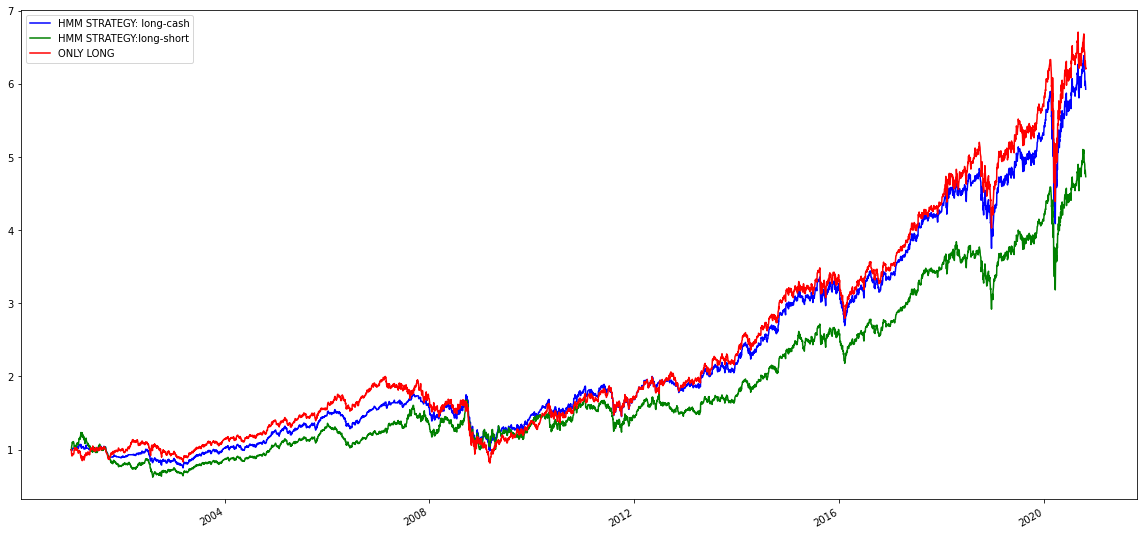

In [109]:
performance_extd(hh.prediction_state.shift(-1)*hh.r1, color = 'blue', label = 'HMM STRATEGY: long-cash')
performance_extd(hh.prediction_state.replace(0, -1).shift(-1)*hh.r1, color = 'green', label = 'HMM STRATEGY: long-short')
performance_extd(hh.r1, label = 'ONLY LONG')
plt.legend()
plt.savefig('../results/CAGR_strategy.png')

Return: 8.24
Volatility: 21.66
Sharpe Ratio: 0.47
Sortino Ratio: 0.67
Calmar Ratio: 0.17
Max Draw-Down: -49.51 Start: 03/13/2001 End: 08/07/2002
Return: 15.36
Volatility: 38.9
Sharpe Ratio: 0.56
Sortino Ratio: 0.8
Calmar Ratio: 0.21
Max Draw-Down: -74.07 Start: 09/14/2007 End: 03/05/2009
Return: 14.05
Volatility: 40.06
Sharpe Ratio: 0.53
Sortino Ratio: 0.75
Calmar Ratio: 0.2
Max Draw-Down: -69.87 Start: 09/07/2007 End: 03/05/2009
Return: 9.74
Volatility: 21.66
Sharpe Ratio: 0.54
Sortino Ratio: 0.77
Calmar Ratio: 0.16
Max Draw-Down: -59.11 Start: 02/20/2007 End: 03/09/2009


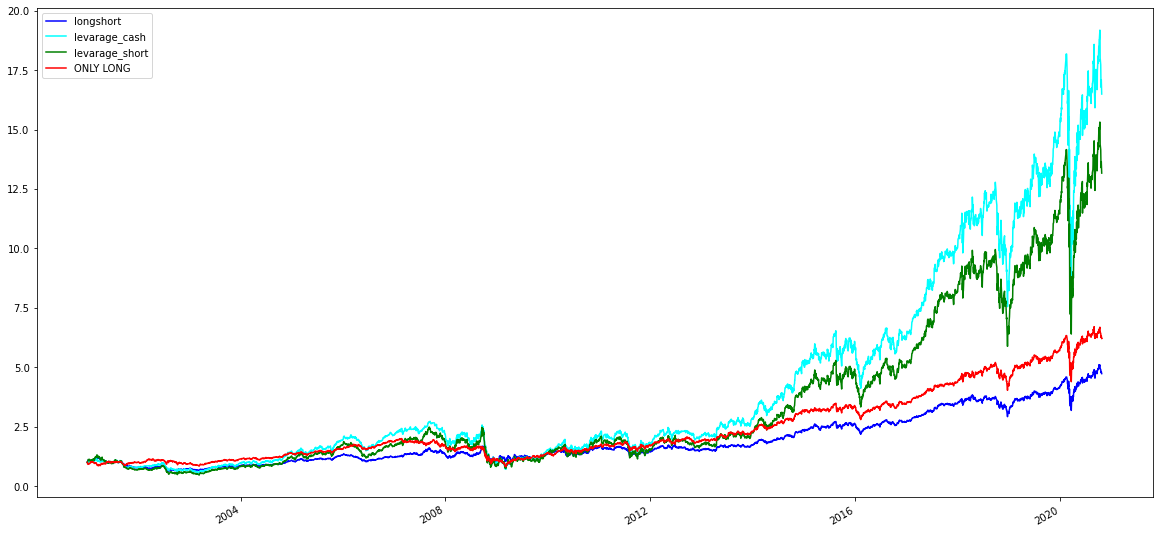

In [106]:
performance_extd(hh.prediction_state.replace(0, -1).shift(-1)*hh.r1, color = 'blue', label = 'longshort')
performance_extd(leverage.shift(-1)*hh.r1, color = 'cyan', label = 'levarage_cash')
performance_extd(leverageshort.shift(-1)*hh.r1, color = 'green', label = 'levarage_short')
performance_extd(hh.r1, label = 'ONLY LONG')
plt.legend()

In [30]:
hh['ret'] = hh.r1
hh['strategy']= hh.prediction_state.shift(-1)*hh.r1

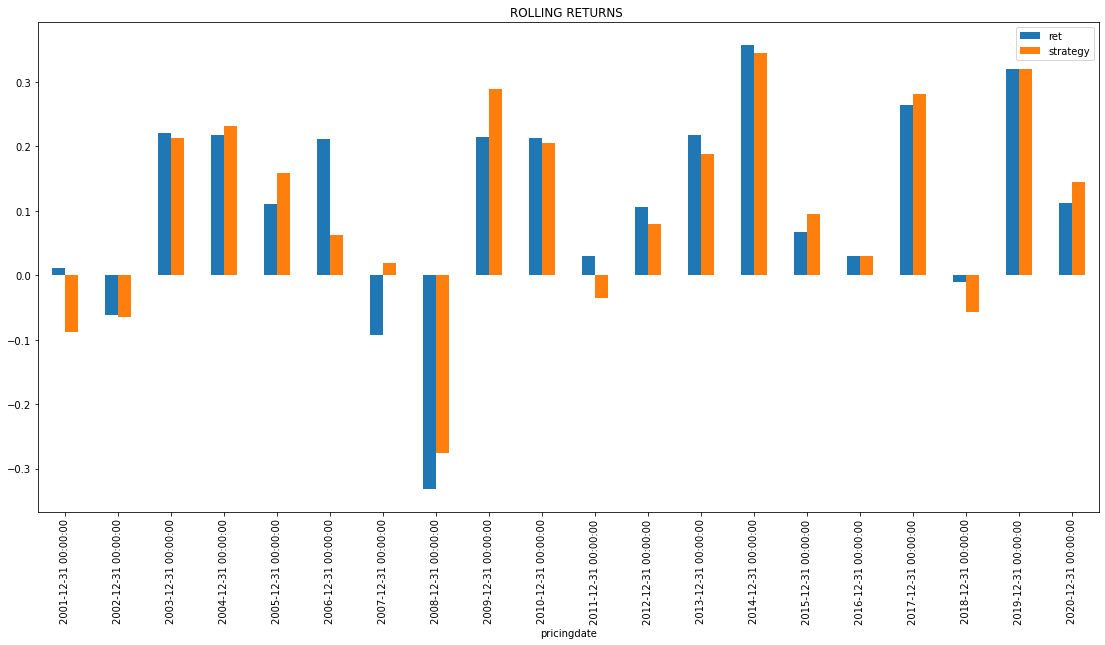

In [71]:
hh[['ret', 'strategy']].groupby(pd.Grouper(freq = 'Y')).apply(lambda x: emp.annual_return(x, annualization = 252)).plot(figsize = (19,9), kind = 'bar')
plt.title('ROLLING RETURNS ')
plt.savefig('../results/rollingbars_strategy.png')

In [64]:
hh.to_csv('../results/result_HMM_randomportfolio1.csv')